# Comparison of results and choice of hyper_params. 

In [47]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from dmd_machine.dmd_ae_machine import DMDMachine
from dmd_machine.loss_function import LossFunction
from data.Data import DataMaker
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
from return_stats import *
from create_plots import *
from dmd_functions import *
from tensorflow import keras
import pickle
import numpy as np
from pydmd import DMD
from numpy import matlib

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['figure.facecolor'] = 'white'
%matplotlib inline

# Step 1: Read in a random test batch. 

In [3]:
fluid_data = pickle.load(open('./data/dataset_fluid.pkl', 'rb'))

In [4]:
# ======================================================================================================================
# Prepare dataset. 
# ======================================================================================================================
data_train, data_test= train_test_split(fluid_data.data_val, test_size=0.0256, random_state=42)

print("dimensions of training dataset (ic x phys_dim x timesteps) = ", np.shape(data_train))
print("dimensions of testing dataset (ic x phys_dim x timesteps) = ", np.shape(data_test))

dimensions of training dataset (ic x phys_dim x timesteps) =  (9744, 3, 121)
dimensions of testing dataset (ic x phys_dim x timesteps) =  (256, 3, 121)


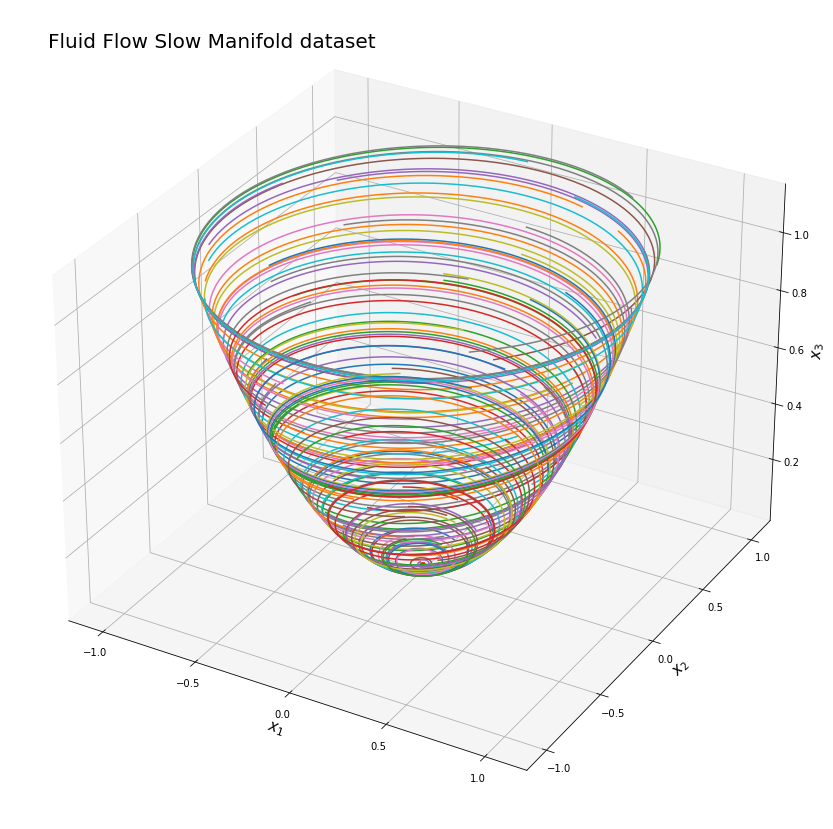

In [5]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, 256, 3):
    ii = int(ii)
    x1 = data_test[ii, 0, :]
    x2 = data_test[ii, 1, :]
    x3 = data_test[ii, 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=15)
ax.set_ylabel("$x_{2}$", fontsize=15)
ax.set_zlabel("$x_{3}$", fontsize=15)
ax.text2D(0.05, 0.95, "Fluid Flow Slow Manifold dataset", transform=ax.transAxes, fontsize=20)
# plt.savefig('fluid_flow.png')
plt.show()

# Evaluate DMD Loss. 


$DMD_{loss}=\arg \min _{A}\left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2}$

$ X^{+} = A \cdot X^{-}$

By the singular value decomposition, 

$ X^{-} = U \cdot \Sigma \cdot V^{T}$

Then, 

$ A = X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*}$,

Hence, 

$ \left\| {X}^{+}- A\cdot X^{-} \right\| _{F}^{2} = 
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot X^{-} \right\| _{F}^{2} =
\left\| {X}^{+}- (X^{+} \cdot V \cdot \Sigma^{-1} \cdot U^{*})\cdot ( U \cdot \Sigma \cdot V^{T}) \right\| _{F}^{2} = 
\left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

$ Loss_{dmd} = \left\| {X}^{+}( I - V \cdot V^{T}) \right\| _{F}^{2}$

In [6]:
def dmd_loss(x_data):
    x_minus = x_data[:, :-1]
    x_plus = x_data[:, 1:]

    U, S, Vt = np.linalg.svd(x_minus, full_matrices=True)

    I = np.identity(np.shape(Vt)[0])

    VVt = np.matmul(np.transpose(Vt), Vt)

    for_norm = np.linalg.norm(np.matmul(x_plus, (I - VVt)), ord='fro')
    
    return for_norm

In [7]:
for_vec_x = np.zeros(np.shape(data_test)[0])

In [8]:
for ii in range(0, np.shape(data_test)[0]):
    loss = dmd_loss(data_test[ii, :, :])
    for_vec_x[ii] = loss

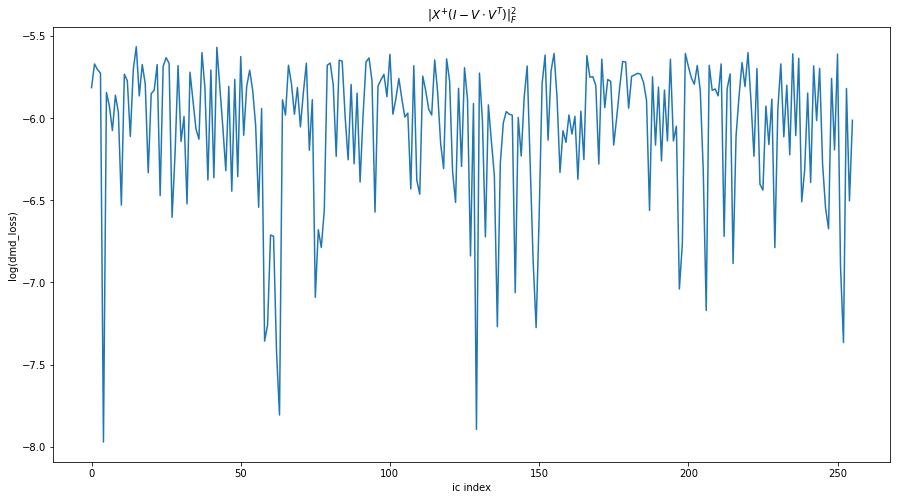

In [9]:
_ = plt.figure(figsize=(15,8))
_ = plt.plot(np.log10(for_vec_x))
_ = plt.ylabel("log(dmd_loss)")
_ = plt.xlabel("ic index")
_ = plt.title("$\| {X}^{+}( I - V \cdot V^{T})\| _{F}^{2}$")

In [10]:
np.mean(for_vec_x)

1.1985157344244937e-06

# Apply DMD Algorithm

In [11]:
def dmd_cmp(Gtot, thrshld):
    mrow, ncol = Gtot.shape
    Ga = np.matlib.repmat((np.mean(Gtot, 1)).reshape(mrow, 1), 1, ncol)
    gfluc = Gtot - Ga
    gm = gfluc[:, :-1]
    gp = gfluc[:, 1:]
    u, s, vh = np.linalg.svd(gm, full_matrices=False)
    sm = np.max(s)
    
    
    indskp = np.log10(s/sm) > -thrshld
    #print("# of singular values = ", indskp)
    sr = s[:sum(indskp)]
    #print(sr)
    ur = u[:, indskp]
    v = np.conj(vh.T)
    vr = v[:, indskp]
    
    kmat = gp @ vr @ np.diag(1./ sr) @ np.conj(ur.T)
    
    evls, evcs = np.linalg.eig(kmat)
    phim = (np.linalg.solve(evcs, gm)).T
    
    return evls, phim, evcs, Ga
    

In [12]:
def recon(phim, evls, evcs, ga):
    b = phim[:, 0]
    rec = np.zeros((phim.shape))
    mags = b
    for i in range(phim.shape[1]):
        rec[:, i] = np.dot(evcs, mags)
        mags = mags*evls
    rec += ga[:, :-1]
    return rec

In [13]:
window_size = 50
random_batch = data_test[:window_size, :, :]

In [14]:
# reshape the matrix to be 15 x timesteps 
reshape_mat = np.zeros((3*window_size, random_batch.shape[-1]))

for ii in range(window_size):
    reshape_mat[3* ii, :] = random_batch[ii, 0, :]
    reshape_mat[3* ii + 1, :] = random_batch[ii, 1, :]
    reshape_mat[3* ii + 2, :] = random_batch[ii, 2, :]

In [15]:
evls, phim, evcs, Ga = dmd_cmp(reshape_mat, 10)

In [16]:
dmd_res = recon(phim.T, evls, evcs, Ga).real

C:\Users\Opali\AppData\Local\Continuum\anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


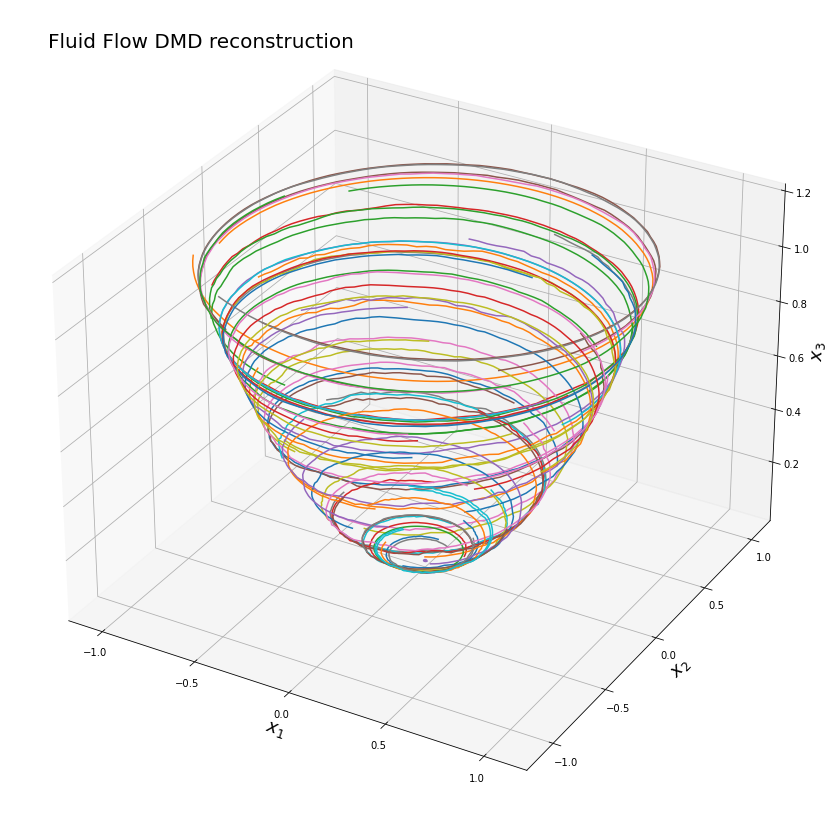

In [17]:
fig = plt.figure(figsize=(15, 15))
ax = plt.axes(projection='3d')

for ii in np.arange(0, random_batch.shape[0]):
    x1 = dmd_res[3* ii, :]
    x2 = dmd_res[3* ii + 1, :]
    x3 = dmd_res[3* ii + 2, :]
    ax.plot3D(x1, x2, x3)

ax.set_xlabel("$x_{1}$", fontsize=18)
ax.set_ylabel("$x_{2}$", fontsize=18)
ax.set_zlabel("$x_{3}$", fontsize=18)
ax.text2D(0.05, 0.95, "Fluid Flow DMD reconstruction", transform=ax.transAxes, fontsize=20)

plt.show()

In [18]:
np.mean((dmd_res - reshape_mat[:,:-1])**2)

3.697595820495377e-06

# Step 3: Load a saved model. 

In [23]:
hyp_params = dict()
hyp_params['num_t_steps'] = 121
hyp_params['phys_dim'] = 3
hyp_params['num_init_conds'] = 1000
hyp_params['batch_size'] = 256 # MAJOR PARAMETER CHOICE
hyp_params['num_epochs'] = 500  # MAJOR PARAMETER CHOICE
hyp_params['window_size'] = 256 # MAJOR PARAMETER CHOICE

# Encoding/Decoding Layer Parameters.
hyp_params['num_en_layers'] = 3
hyp_params['num_en_neurons'] = 80
hyp_params['latent_dim'] = 3
hyp_params['window_size'] = 256

hyp_params['activation'] = 'elu'
hyp_params['weight_initializer'] = 'he_uniform'
hyp_params['bias_initializer'] = 'he_uniform'
hyp_params['ae_output_activation'] = "linear"
hyp_params['hidden_activation'] = "elu"

hyp_params['c1'] = 10  # coefficient auto-encoder loss.
hyp_params['c2'] = 1  # coefficient of dmd loss.
hyp_params['c3'] = 1  # coefficient of pred loss.

myMachine = DMDMachine(hyp_params)

print("DMD Loss on input dataset = ", (myMachine.get_linearity_loss(tf.convert_to_tensor(data_test)).numpy()))
y_pred_reshape =  DMDMachine.compute_predict_batch_reshape(myMachine, y_data_mat=tf.convert_to_tensor(data_test))
print("Pred Loss on input dataset = ", (myMachine.pred_loss(tf.convert_to_tensor(data_test), y_pred_reshape)).numpy())


DMD Loss on input dataset =  5.453337e-06
Pred Loss on input dataset =  4.305547e-08


In [24]:
# Load results from Dec 13th -- latent space dimensions are 2 (instead of 3)! 

hyp_params['latent_dim'] = 2
myMachine = DMDMachine(hyp_params)

myMachine.autoencoder.encoder = keras.models.load_model("./models/encAeEx3_2020-12-13", compile=False)
myMachine.autoencoder.decoder = keras.models.load_model("./models/decAeEx3_2020-12-13", compile=False)

In [25]:
test_run = myMachine(data_test)

# Step 3: Plot results.

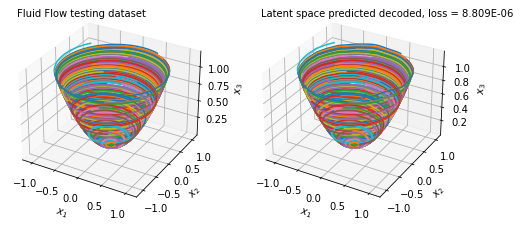

In [40]:
create_plots_fluid_pred(data_test, test_run, hyp_params, 0, "figures", data_type="test", compare_models=True)

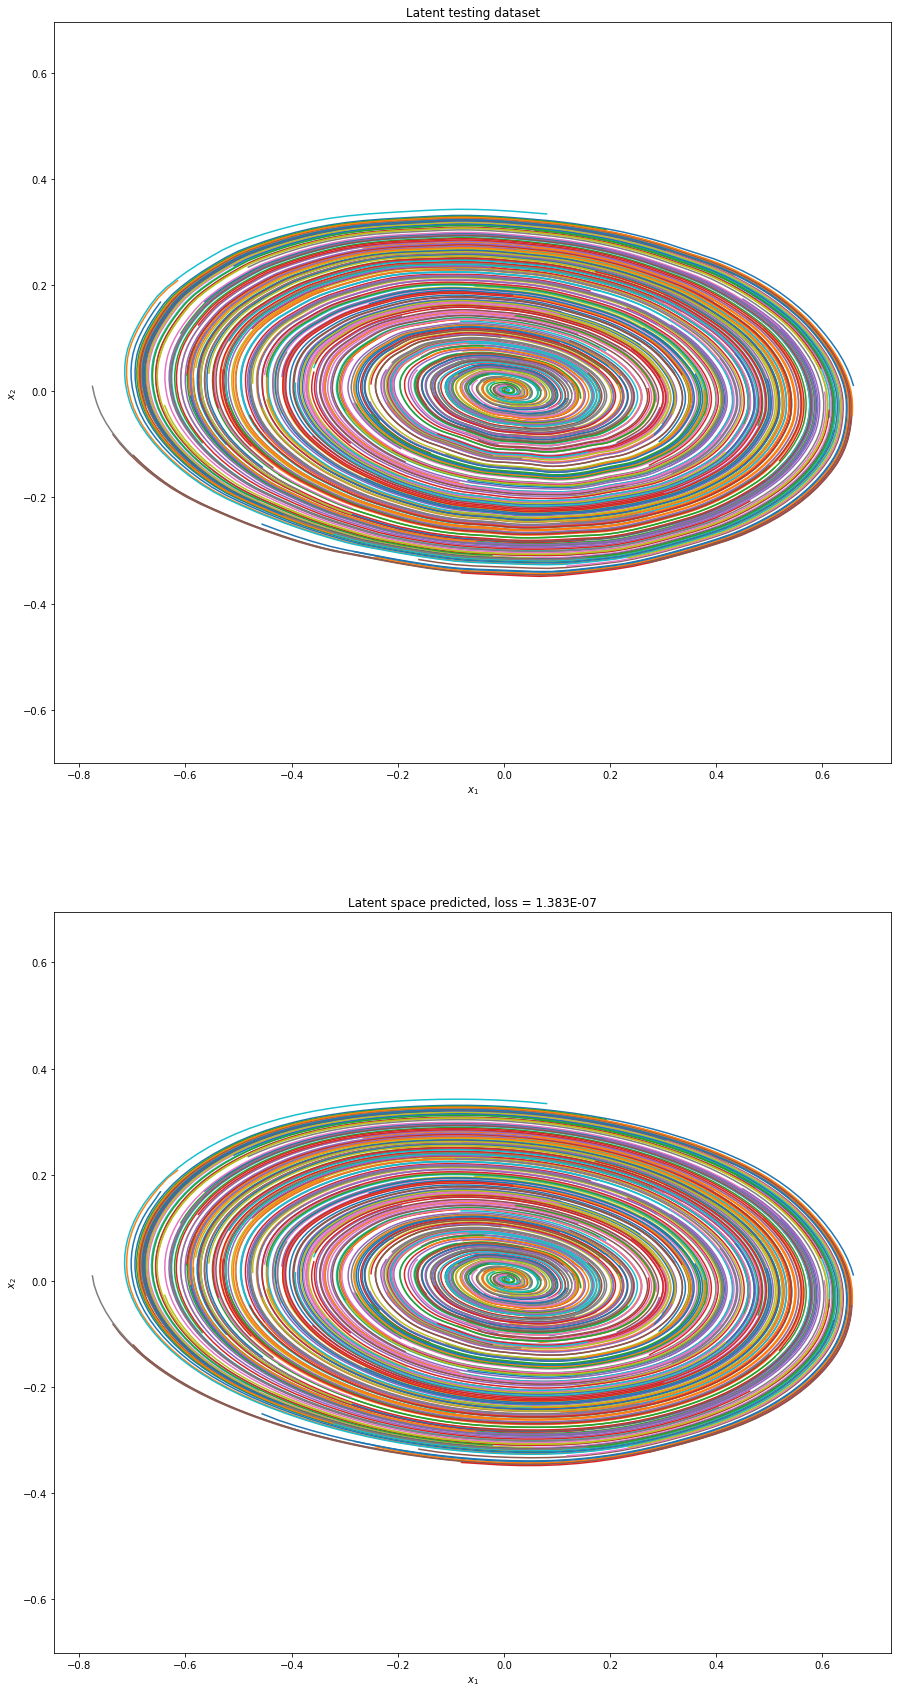

In [49]:
create_plots_fluid_latent_2d(test_run, hyp_params, 0, "figures", data_type="test", compare_models=True)

In [56]:
print("dmd loss = " , test_run[2].numpy())
print("autoencoder loss = ", test_run[3].numpy())
print("prediction loss = ", test_run[5].numpy())
print("decode predicted reconstruction loss = ", test_run[7].numpy())

dmd loss =  6.845221e-05
autoencoder loss =  2.0304207e-05
prediction loss =  1.3834594e-07
decode predicted reconstruction loss =  8.8090155e-06


# Step 4: Repeat for all models saved. 